In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.combine import SMOTETomek
import shap 
pd.set_option('display.max_columns',30)

In [3]:
train = pd.read_csv('Cleaned_data/Train_dataset.csv', index_col=0)
test = pd.read_csv('Cleaned_data/Test_dataset.csv', index_col=0)
#test = pd.read_csv('Cleaned_data/New_test_dataset.csv', index_col=0)

In [4]:
train.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)
test.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail','new_date'], inplace=True)
train.head()
train['failure_actual_fail'].value_counts()

0    31277
1      836
Name: failure_actual_fail, dtype: int64

# Method 2 split data - Using train_test_split directly

In [5]:
train_features = train.drop(columns=['failure_actual_fail'])
train_y = train[['failure_actual_fail']]
test_features = test.drop(columns=['failure_actual_fail'])
test_y = test[['failure_actual_fail']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.3, random_state = 1)
X_test, test_features, y_test, test_y =  train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(test_features.shape)
print(test_y.shape)

(22479, 25)
(4817, 25)
(22479, 1)
(4817, 1)
(4817, 25)
(4817, 1)


In [8]:
print(y_train['failure_actual_fail'].value_counts())
print(y_test['failure_actual_fail'].value_counts())
print(test_y['failure_actual_fail'].value_counts())

0    21923
1      556
Name: failure_actual_fail, dtype: int64
0    4673
1     144
Name: failure_actual_fail, dtype: int64
0    4681
1     136
Name: failure_actual_fail, dtype: int64


## Creating balanced training set (Equal fails and no fails)

### Using pacakge

In [9]:
#basic over sample (5:1 negative-positive)
basicOS = RandomOverSampler(sampling_strategy=0.05) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

#smote over sample (5:1 negative-positive)
smoteOS = SMOTE(sampling_strategy=0.33) #can set the proportion of minority/total
train_smoteOS, label_smoteOS = smoteOS.fit_resample(X_train,y_train)

#basic under sample
basicUS = RandomUnderSampler(sampling_strategy=0.33)
train_basicUS,label_basicUS = basicUS.fit_resample(X_train,y_train)

print(X_train.shape)
print(y_train.value_counts())

print(train_basicOS.shape)
print(label_basicOS.value_counts())

print(train_smoteOS.shape)
print(label_smoteOS.value_counts())

print(train_basicUS.shape)
print(label_basicUS.value_counts())

(22479, 25)
failure_actual_fail
0                      21923
1                        556
dtype: int64
(23019, 25)
failure_actual_fail
0                      21923
1                       1096
dtype: int64
(29157, 25)
failure_actual_fail
0                      21923
1                       7234
dtype: int64
(2240, 25)
failure_actual_fail
0                      1684
1                       556
dtype: int64


In [10]:
from sklearn.metrics import recall_score
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    print(f'Recall: {round(tp/(fn+tp) * 100, 2)}%')
    print(f'Precision: {round(tp/(fp+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

## Training Models - XGBoost mainly with hyperparameter tuning

tn: 4669, fp: 4,
fn: 78,   tp: 66
FNR: 54.17%
Recall: 45.83%
Precision: 94.29%


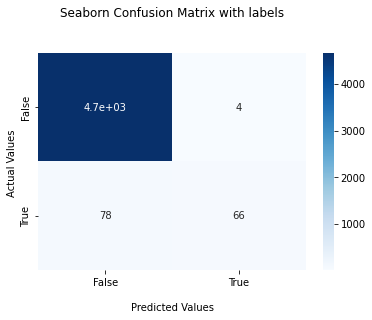

In [11]:
xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

tn: 4665, fp: 8,
fn: 78,   tp: 66
FNR: 54.17%
Recall: 45.83%
Precision: 89.19%


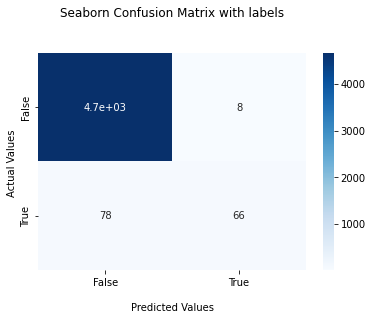

In [12]:
xgbc = XGBClassifier(verbosity = 0, n_estimators = 400, learning_rate = 0.05)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

<AxesSubplot:xlabel='failure_actual_fail', ylabel='count'>

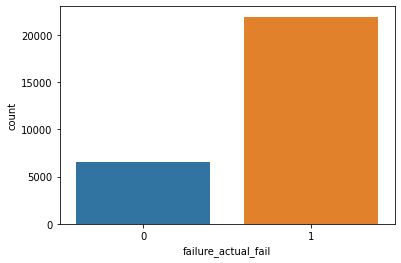

In [13]:
smtomek = SMOTETomek(random_state=2331)
x_train_temp, y_train_temp = smtomek.fit_resample(X_train, y_train)
total_train = pd.concat([x_train_temp, y_train_temp], axis=1)
positives = total_train[total_train['failure_actual_fail'] == 1]
negatives = total_train[total_train['failure_actual_fail'] == 0]
negatives = negatives.sample(frac=0.3, random_state=1)
total_train = pd.concat([positives, negatives])
x_train_1 = total_train.drop(columns='failure_actual_fail')
y_train_1 = total_train[['failure_actual_fail']]
sns.countplot(y_train_1['failure_actual_fail'])

tn: 4607, fp: 66,
fn: 50,   tp: 94
FNR: 34.72%
Recall: 65.28%
Precision: 58.75%


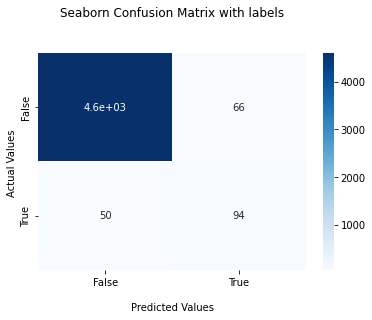

In [14]:
# xgbc = xgb.XGBClassifier(verbosity = 0)
# # xgbc_cv = cross_val_score(xgbc, x_train_1, y_train_1, scoring='recall', cv=5)
# # print(xgbc_cv)

# # xgbc_cv = cross_val_score(xgbc, x_train_1, y_train_1, scoring='precision', cv=5)
# # print(xgbc_cv)

xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(x_train_1, y_train_1)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

<AxesSubplot:xlabel='failure_actual_fail', ylabel='count'>

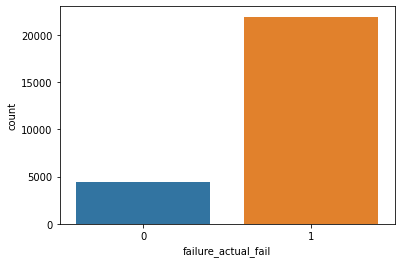

In [15]:
smtomek = SMOTETomek(random_state=2331)
x_train_temp, y_train_temp = smtomek.fit_resample(X_train, y_train)
total_train = pd.concat([x_train_temp, y_train_temp], axis=1)
positives = total_train[total_train['failure_actual_fail'] == 1]
negatives = total_train[total_train['failure_actual_fail'] == 0]
negatives = negatives.sample(frac=0.2, random_state=1)
total_train = pd.concat([positives, negatives])
x_train_2 = total_train.drop(columns='failure_actual_fail')
y_train_2 = total_train[['failure_actual_fail']]
sns.countplot(y_train_2['failure_actual_fail'])

tn: 4583, fp: 90,
fn: 51,   tp: 93
FNR: 35.42%
Recall: 64.58%
Precision: 50.82%


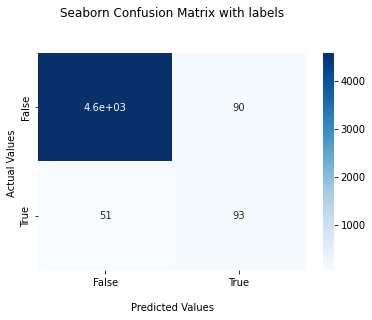

In [16]:
xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(x_train_2, y_train_2)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

<AxesSubplot:xlabel='failure_actual_fail', ylabel='count'>

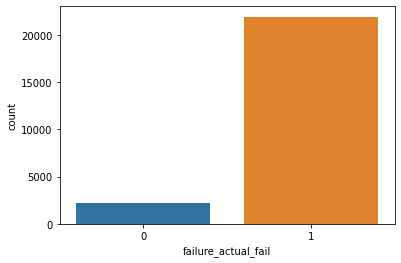

In [17]:
smtomek = SMOTETomek(random_state=22)
x_train_temp, y_train_temp = smtomek.fit_resample(X_train, y_train)
total_train = pd.concat([x_train_temp, y_train_temp], axis=1)
positives = total_train[total_train['failure_actual_fail'] == 1]
negatives = total_train[total_train['failure_actual_fail'] == 0]
negatives = negatives.sample(frac=0.1, random_state=1)
total_train = pd.concat([positives, negatives])
x_train_3 = total_train.drop(columns='failure_actual_fail')
y_train_3 = total_train[['failure_actual_fail']]
sns.countplot(y_train_3['failure_actual_fail'])

tn: 4479, fp: 194,
fn: 39,   tp: 105
FNR: 27.08%
Recall: 72.92%
Precision: 35.12%


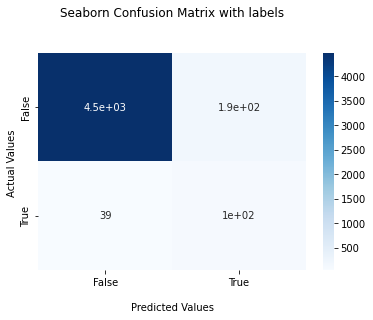

In [18]:
xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(x_train_3, y_train_3)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## Hyperparameter

Learning rate

In [19]:
param_test7 = {
 'learning_rate':[0.05,0.1,0.3,0.5,1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='recall',n_jobs=2,cv=4)
gsearch7.fit(x_train_2, y_train_2)
gsearch7.best_params_, gsearch7.best_score_

({'learning_rate': 0.05}, 0.9849479938660028)

tn: 4493, fp: 180,
fn: 44,   tp: 100
FNR: 30.56%
Recall: 69.44%
Precision: 35.71%


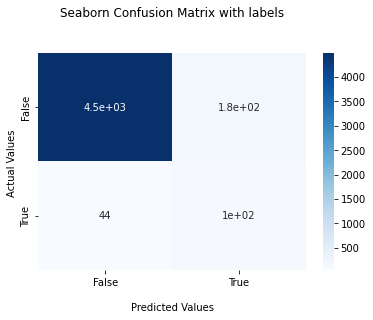

In [20]:
xgbc = gsearch7.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

In [31]:
param_test1 = {
 'max_depth':range(7,12),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='recall',n_jobs=2,cv=4)
gsearch1.fit(x_train_2, y_train_2)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 11, 'min_child_weight': 1}, 0.9849936143039592)

tn: 4566, fp: 107,
fn: 49,   tp: 95
FNR: 34.03%
Recall: 65.97%
Precision: 47.03%


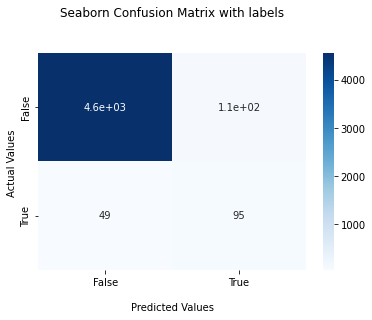

In [32]:
xgbc = gsearch1.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

n_estimators

In [33]:
param_test8 = {
 'n_estimators':[50,200,400,500]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.05, colsample_bytree = 0.8, reg_alpha = 0, gamma = 0.1,
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27, max_depth = 8), 
 param_grid = param_test8, scoring='recall',n_jobs=2,cv=4)
gsearch8.fit(x_train_2, y_train_2)
gsearch8.best_params_, gsearch8.best_score_

({'n_estimators': 400}, 0.9848567779602262)

In [34]:
gsearch8.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=2, nthread=2, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

tn: 4581, fp: 92,
fn: 49,   tp: 95
FNR: 34.03%
Recall: 65.97%
Precision: 50.8%


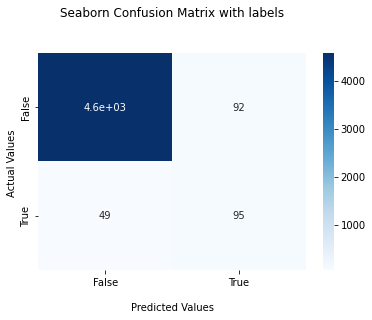

In [35]:
xgbc = gsearch8.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

#### Stage 2

Tune gamma

In [28]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='recall',n_jobs=2,cv=4)
gsearch3.fit(x_train_2, y_train_2)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, 0.9837620872103631)

tn: 4569, fp: 104,
fn: 49,   tp: 95
FNR: 34.03%
Recall: 65.97%
Precision: 47.74%


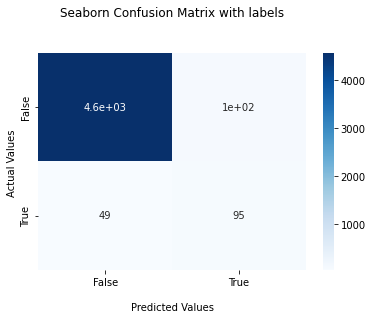

In [29]:
xgbc = gsearch3.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tune subsample and colsample_bytree

In [36]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='recall',n_jobs=2,cv=4)
gsearch4.fit(x_train_2, y_train_2)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.984081363689028)

tn: 4576, fp: 97,
fn: 46,   tp: 98
FNR: 31.94%
Recall: 68.06%
Precision: 50.26%


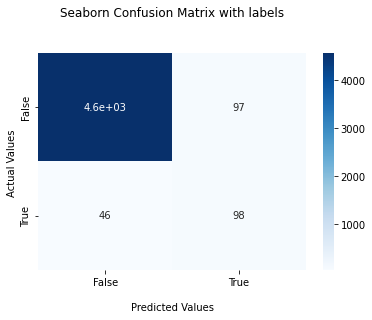

In [37]:
xgbc = gsearch4.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tuning Regularization Parameters

In [38]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='recall',n_jobs=2,cv=4)
gsearch5.fit(x_train_2, y_train_2)
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 100}, 0.9872285163610988)

tn: 4281, fp: 392,
fn: 42,   tp: 102
FNR: 29.17%
Recall: 70.83%
Precision: 20.65%


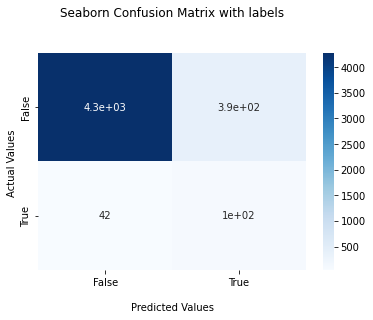

In [39]:
xgbc = gsearch5.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

tn: 4228, fp: 445,
fn: 37,   tp: 107
FNR: 25.69%
Recall: 74.31%
Precision: 19.38%


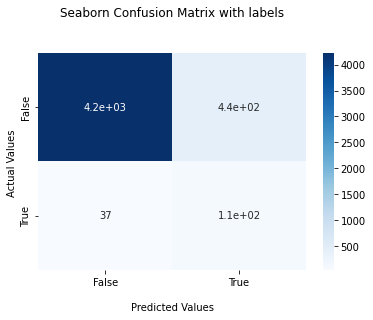

In [51]:
xgbc = XGBClassifier(objective= 'binary:logistic', scale_pos_weight=1, seed=27, learning_rate = 0.05, 
max_depth=11, min_child_weight=1, n_estimators=400, gamma=0.2, colsample_bytree=0.9, subsample=0.8, 
reg_alpha=200)
xgbc.fit(x_train_2,y_train_2)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

tn: 4219, fp: 462,
fn: 39,   tp: 97
FNR: 28.68%
Recall: 71.32%
Precision: 17.35%


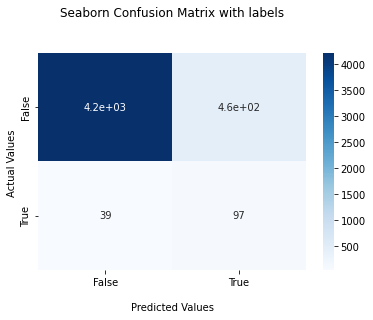

In [52]:
y_pred = xgbc.predict(test_features)
cf_matrix = confusion_matrix(test_y, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)